# DQN - Pytorch
- Pytorch tutorial for DQN: http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- INPUT: patch of the screen centered on the cart

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn  # Neural Networks
import torch.optim as optim  # Optimization
import torch.nn.functional as F
from torch.autograd import Variable  # Automatic Differentiation
import torchvision.transforms as T

In [2]:
env = gym.make('CartPole-v0').unwrapped
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
is_ipython = False
    
plt.ion()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Replay Memory
- By sampling from it randomly, the transitions that build up a batch are decorrelated
- `Transition` - a named tuple representing a single transition in our environment
- `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a `.sample()` method for selecting a random batch of transitions for training.

In [4]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN
- Return: $R_{t_0} = \sum_{t=t_0}^\infty \gamma^{t-t_0} r_t$
- Optimal policy: $\pi^*(s) = \arg \max_a Q^*(s,a)$
- Bellman equation: $Q(s,a) = r + \gamma Q^\pi(s', \pi(s'))$
- Temporal Difference error: $\delta = Q(s,a) - (r + \gamma \max_a Q(s', a))$
- **Huber loss**: Using a batch $B$ of transitions, $$\mathcal{L} = \frac{1}{|B|} \sum_{(s,a,s',s)\in B} \mathcal{L}(\delta)$$
where 
\begin{equation}
  \mathcal{L}(\delta)=\begin{cases}
    \frac{1}{2}\delta^2, & \text{for $|\delta| \leq 1$},\\
    |\delta| - \frac{1}{2}, & \text{otherwise}.
\end{cases}
\end{equation}

In [5]:
class DQN(nn.Module):
    """CNN that takes as input the difference between current and previous screen patches (s). 
    It has two outputs, Q(s, left) and Q(s, right)"""
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))  # view: reshape tensor

# Input extraction functions

In [6]:
resize = T.Compose([T.ToPILImage(),
                   T.Scale(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

# Based on the code from gym
screen_width = 600

def get_cart_location():
    world_width = env.x_threshold*2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # Transpose into TORCH ORDER (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                           cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor (this doesn't need a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch of dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

/home/desteban/anaconda3/envs/py36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


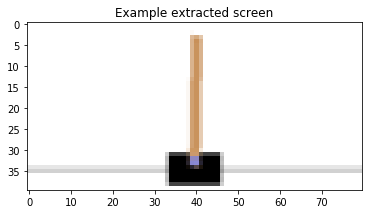

In [7]:
env.reset()
plt.figure()
# squeeze: Returns a tensor with all the dimensions of input of size 1 removed.
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()
# env.close()

# Training
- `Variable` - this is a simple wrapper around torch.autograd.Variable that will automatically send the data to the GPU every time we construct a Variable.
- `select_action` - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.
- `plot_durations` - a helper for plotting the durations of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])

    
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        # cat: Concatenates the given sequence of seq tensors in the given dimension
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # Pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

# Training Loop
- `optimize_model` performs a single step of the optimization. It first samples a batch, concatenates all the tensors into a single one, computes $Q(s_t,a_t)$ and $V(s_{t+1})=\max_a Q(s_{t+1}, a)$, and combines them into our loss. By defition we set $V(s)=0$ if s is a terminal state.

In [9]:
last_sync = 0

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    
    # We don't want to backprop through the expected action values and volatile
    # will save us on temporaly changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state if s is not None]),
                                    volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    # Compute Q(S_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    # gather: Gathers values along an axis specified by dim.
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

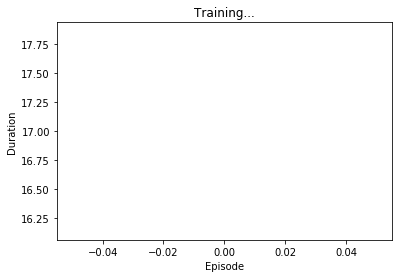

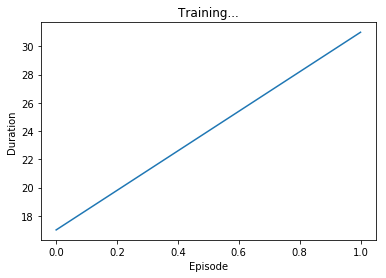

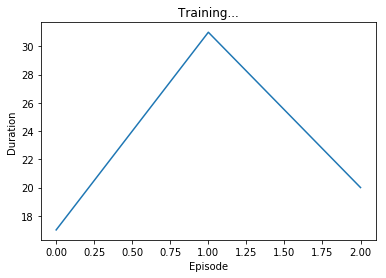

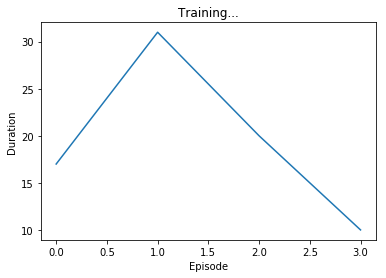

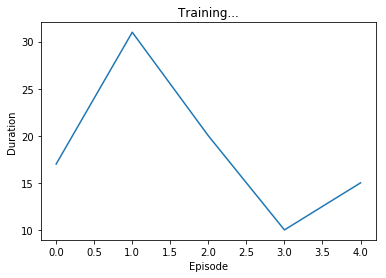

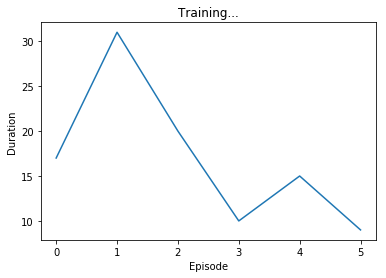

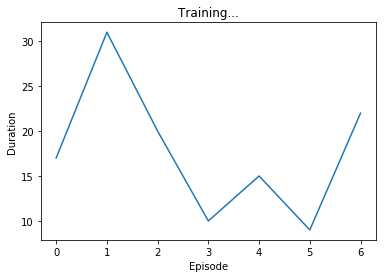

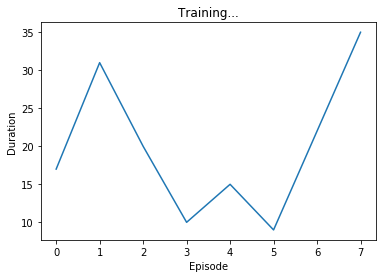

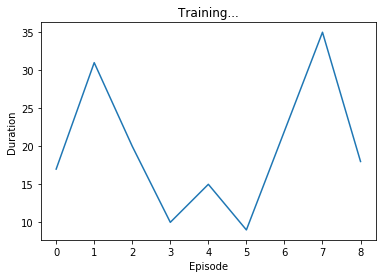

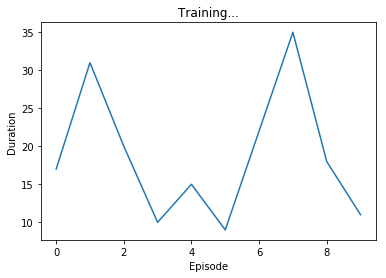

Complete


In [10]:
num_episodes = 10
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
# env.render(close=True)
env.close()
plt.ioff()
plt.show()

In [11]:
plt.show()